In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from sklearn.cluster import KMeans
# from gseapy.plot import barplot, dotplot
from matplotlib.pyplot import cm
# import rpy2
# from rpy2.robjects import pandas2ri
# import anndata2ri
import logging
import scvi
from scipy import stats
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import adobo.hvg as hvg
import magic
import json
import requests
# import gseapy as gp
# importlib.reload(gp)
# Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

adobo version 0.2.70. Documentation: https://oscar-franzen.github.io/adobo/


In [3]:
# %%R

# .libPaths(c('/u/davidm/R/x86_64-pc-linux-gnu-library/3.6','/soft/bioinfo/linux_RH7/R-3.6.1/lib64/R/library'))

# # Load all the R libraries we will be using in the notebook
# library(MAST)

In [4]:
sys.path.append("/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/")

In [5]:
import RNAseq
importlib.reload(RNAseq)

<module 'RNAseq' from '/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/RNAseq.py'>

### Constants and paths

In [6]:
annot_path = "/home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/"

### Plotting parameters

In [7]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

In [8]:
# cell line
b = {"BT20" : "dodgerblue", "HCC70" : "rebeccapurple", "MDAMB231": "seagreen", "MDAMB436": "tab:olive", "SKBR3": "palevioletred", "MCF7-atcc":"brown", "MCF7-labo":"gold", "ZR75":"chocolate","T47D":"gray", "nt" : "pink", "er1" : "teal", "er2" : "coral", "ctrl" : "slateblue", "EV":"tab:orange", "VGLL1":"tab:blue", "GRHL2":"tab:purple", "PMIG" : "turquoise"}

In [9]:
b.keys()

dict_keys(['BT20', 'HCC70', 'MDAMB231', 'MDAMB436', 'SKBR3', 'MCF7-atcc', 'MCF7-labo', 'ZR75', 'T47D', 'nt', 'er1', 'er2', 'ctrl', 'EV', 'VGLL1', 'GRHL2', 'PMIG'])

### Loading datasets

In [26]:
sc1 = RNAseq.sc_Dataset(project_path = "/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-BC-cell-lines_DSP992", samples_id = "cell_lines", samples= 'all', quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "filtered/non-stringent", cdna = "3' tag")

Annotating cell_lines...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [11]:
sc1.mtx.shape

(6991, 20305)

In [27]:
sc2 = RNAseq.sc_Dataset(project_path = "/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-BC-cell-lines_DSP762", samples_id = "cell_lines", samples= "all", quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "filtered/non-stringent", cdna = "3' tag")
sc2.annotate_genes(genes_annot_name="external_gene_name")
sc2.save()

Annotating cell_lines...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [15]:
sc2.mtx.shape

(5280, 20305)

In [28]:
sc3 = RNAseq.sc_Dataset(project_path = "/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-MCF7-siRNA_DSP779", samples_id = "cell_lines", samples= 'all', quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "filtered/non-stringent", cdna = "3' tag")
# sc3.annotate_samples(samples_annot_name = "cell_lines", samples_annot = "MCF7-labo-nt")

Annotating cell_lines...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [17]:
sc4 = RNAseq.sc_Dataset(project_path = f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-MCF7+MDAMB231-pmig-GRHL2_DSP1090", samples_id = "cell_lines", samples= "all", quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "filtered", cdna = "3' tag")

Annotating cell_lines...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [29]:
sc = RNAseq.merge_datasets([sc1, sc2, sc3], annot_name = "project", annot = ["dsp992", "dsp762", "dsp779"], genes_set = "max")
sc.filter_genes(n_samples = 5, n_counts = 2)
sc.annotate_genes(genes_annot_name = "external_gene_name", save_path = annot_path + "/biomart_ens100")
del sc1, sc2, sc3
sc.save()

Annotating project...
Annotating #_genes...
Annotating barcodes...
Annotating cell_lines...
Annotating total_UMIs...
Annotating external_gene_name using /home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34//biomart_ens100/ensembl_gene_id-to-external_gene_name.csv...


In [19]:
sc.cell_lines

array(['MDAMB231', 'MDAMB231', 'MDAMB231', ..., 'MCF7-atcc', 'MCF7-atcc',
       'MCF7-atcc'], dtype='<U9')

In [20]:
sc.get_layer("mtx").shape

(15219, 12555)

In [25]:
b = sc.barcodes

In [15]:
import matplotlib.colors as cl

In [32]:
def dim_reduc(sc, method = "pca", layer = "log_norm_mtx", color_by = "total_UMIs", color_layer = "log_norm_mtx", color_dict = None, color_log_scale = False, \
    genes_annot_name = "external_gene_name", plot = True, markersize = 2, markerscale = 8, color_norm = 1, vmax = None, ow = False, **kwargs) :

    run = (method not in sc.layers["reduced"]) or (ow == True)

    l = sc.get_layer(layer)
    if method == "pca" :
        new_dims = PCA(**kwargs).fit_transform(l) if run else sc.get_layer(method)
        label = "PC"
    elif method == "umap" :
        new_dims = umap.UMAP(**kwargs).fit_transform(l) if run else sc.get_layer(method)
        label = "UMAP"
    elif method == "phate" :
        new_dims = PHATE(**kwargs).fit_transform(l) if run else sc.get_layer(method)
        label = "PHATE"


    if run :
        setattr(sc, method, new_dims)
        sc.layers["reduced"].append(method) if method not in sc.layers["reduced"] else None ######### not very elegant
    else :
        print(f"Already performed {method}. To overwrite, set ow = True.")

    if plot :

        color = getattr(sc, color_by) if color_by in sc.annotations["samples"] else \
            sc.select_genes(genes_annot_name = genes_annot_name, genes_annot = color_by, return_layer = color_layer)[1]
        color_title = (' ').join(color_by.split('_'))

        fig, ax = plt.subplots(figsize=(12,9))
        
        d = sc.get_layer(method)
        if type(color[0]) == np.str_ :
            for s in np.unique(color) :
#                 _, d = sc.select_samples(samples_annot_name = color_by, samples_annot = s, return_layer = method)
                i = color == s
                if color_dict is None :
                    scatter = ax.scatter(x = d[i,0], y = d[i,1], label = s, s = markersize)
                else :
                    scatter = ax.scatter(x = d[i,0], y = d[i,1], label = s, c = color_dict[s], s = markersize)
                legend = ax.legend(title = color_title, prop={'size': 12}, markerscale = markerscale)
                legend.get_title().set_fontsize('14')

        else :
            vmax = np.max(sc.select_genes(genes_annot_name = genes_annot_name, genes_annot = vmax, \
                return_layer = color_layer)[1]) if type(vmax) == str else (np.max(color) if vmax is None else vmax)
            if color_log_scale :
                norm = cl.LogNorm(vmax = vmax)
            else :
                norm = cl.PowerNorm(vmax = vmax, gamma = color_norm) 
            plt.scatter(x = new_dims[:,0], y = new_dims[:,1], c = color, s = markersize, norm = norm)
            # plt.title("PCA on log-normalized counts")
            cb = plt.colorbar()
            cb.ax.set_title(color_title)

        plt.xlabel(label + "1", fontsize = 14)
        plt.ylabel(label + "2", fontsize = 14)


In [38]:
sc.reload()
# sc.shuffle_cells()
sc.lib_size_normalization(plot = False)
sc.dim_reduc(method = "pca", n_components = 50, plot = False)

Already performed umap. To overwrite, set ow = True.


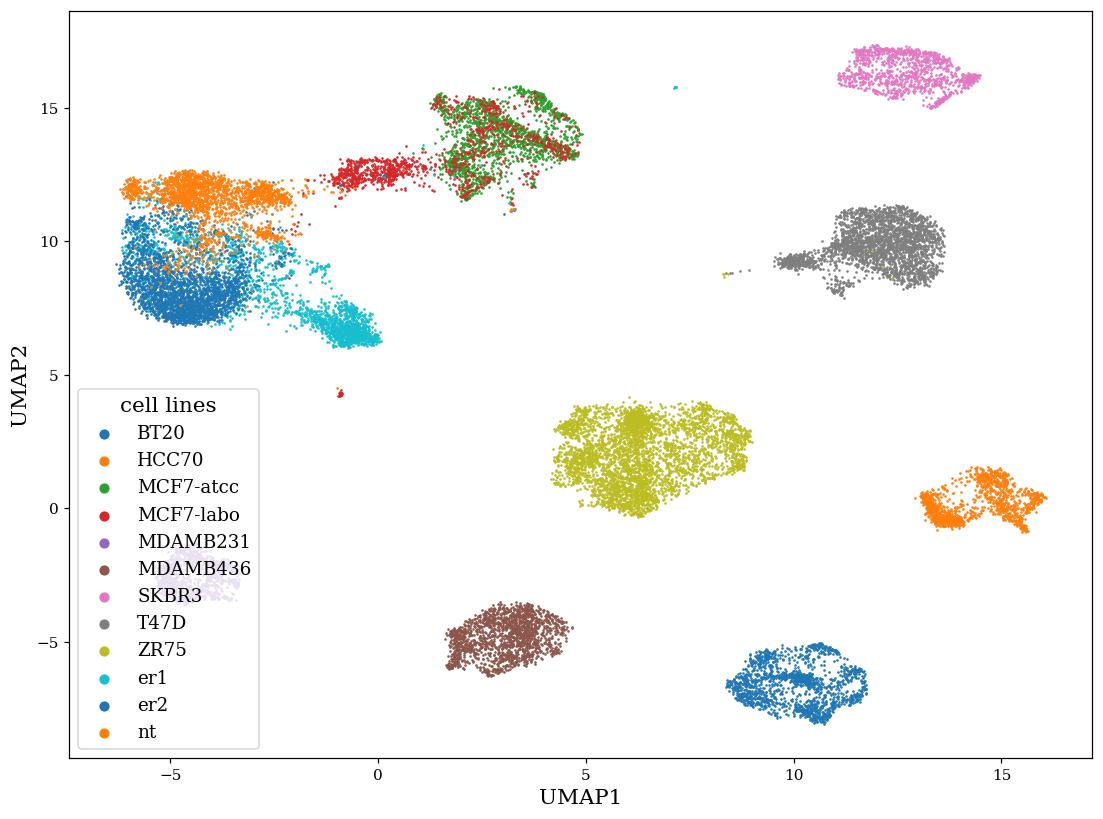

In [54]:
dim_reduc(sc, method = "umap", layer = "pca", color_by = "cell_lines", markersize = 0.5, n_neighbors = 12, min_dist = 0.3)

In [51]:
stringent = np.array(["kept" if br in b else "removed" for br in sc.barcodes])
sc.annotate_samples(samples_annot_name="stringent", samples_annot=stringent.astype(str), ow = True)

Annotating stringent...


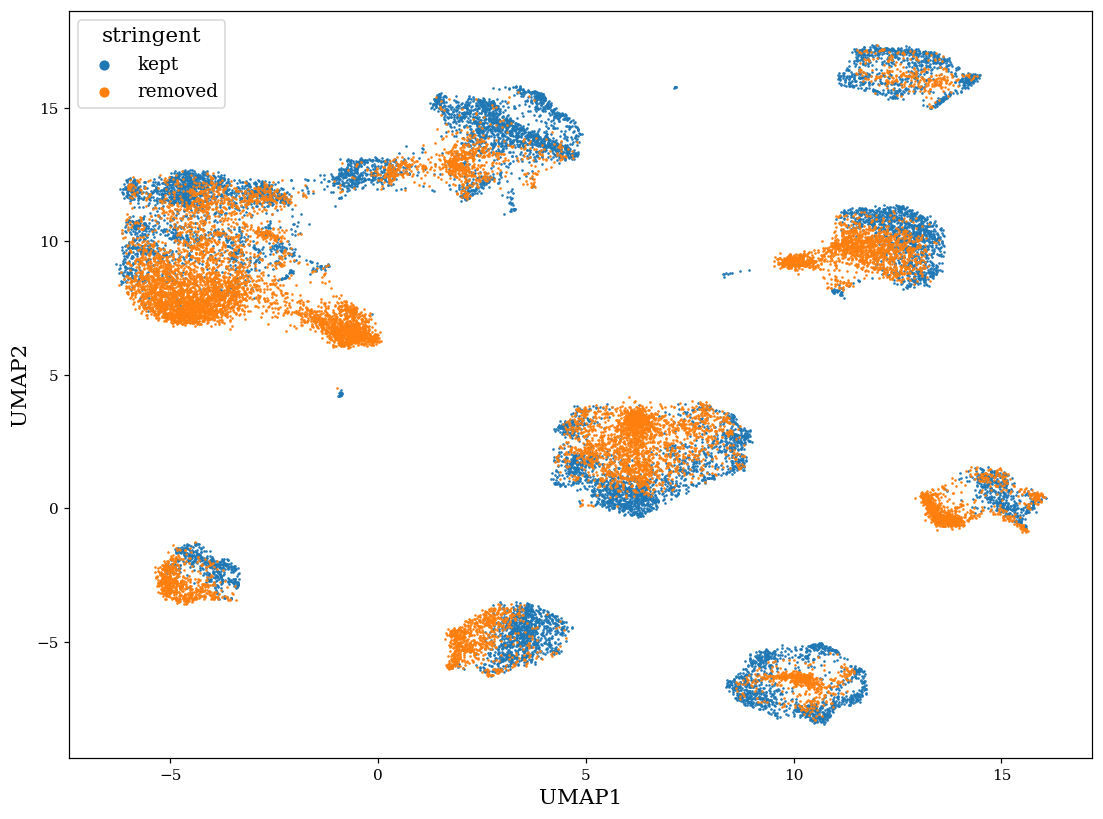

In [52]:
dim_reduc(sc, method = "umap", layer = "pca", color_by = "stringent", markersize = 0.5, n_neighbors = 12, min_dist = 0.3, ow = True)

Already performed umap. To overwrite, set ow = True.


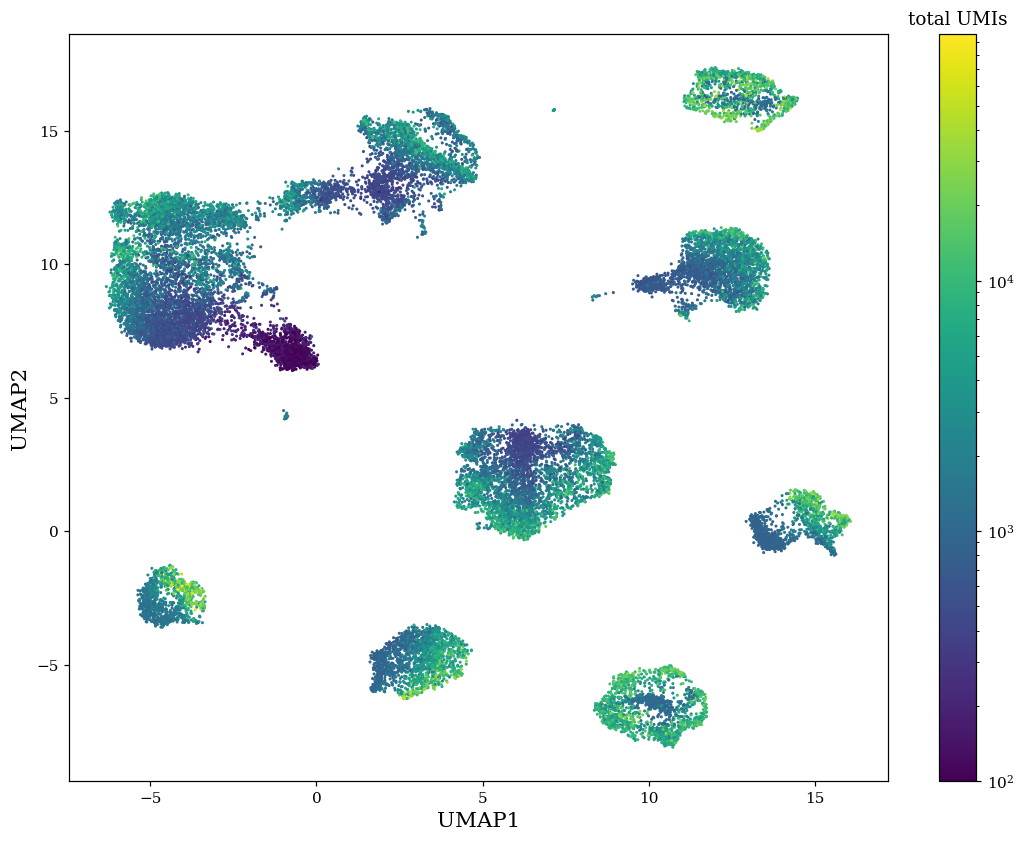

In [53]:
dim_reduc(sc, method = "umap", layer = "pca", color_by = "total_UMIs",  color_log_scale=True, markersize = 1, min_dist = 0.2)